# ID3 decison tree from scratch

Below is a class assignment where we had to implement a machine learning algorithm from a scratch, and I choose a vanilla ID3 decision tree. It is only good for toy problems, but it is a good demonstration of the concepts, and it may be useful to someone coming to data science from a software engineering background. 

### The Import Block

In [1]:
%matplotlib inline
import numpy as np

from sklearn import datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt

### Some Useful functions

In [2]:
def calculate_entropy(y):
   #  y is an n X 1 sized matrix where n is the number of data points (targets). The return is a scalar.
   # ....I'm assuming he wants the entropy of the empirical distribution? 
    
    number_of_datapoints = len(y)
    list_of_classes = np.unique(y)  # list of each outcome type.
    total_entropy = 0 
    
    # counts for each outcome class. We use broadcasting and list comprehensions to get the total counts for each class. 
    counts = [y == a for a in list_of_classes]       
    counts = np.array([counts[i].sum() for i in range(len(list_of_classes))])
    counts = counts/number_of_datapoints                 # counts then normalized against total # of datapoints. 
    
    inverse_counts = 1/counts
    total_entropy += np.log2(inverse_counts) * counts
    total_entropy = total_entropy.sum()
    return (total_entropy)

In [3]:
def find_split(x, y):
    
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # Need the starting entropy so we can measure improvement...
    pre_split = calculate_entropy(y)
    
    
    best = {'infogain' : -np.inf}              # Best thus far, initialised to a dud that will be replaced immediately..
    max_indice = len(x) - 1                    # highest indice in the feature table. 
    total_datapoints = len(x)                  # total number of datapoints in the feature table. 
    
    
    
    # Loop every possible split of every dimension...
    for i in range(x.shape[1]):
        for split in np.unique(x[:,i]):
            
            # separating indices into left and right for each data point . 
            left_indices  = [j for j in range(0, max_indice) if x[j, i] <= split ]
            right_indices = [j for j in range(0, max_indice) if x[j ,i] > split ]
            
            # weighted entropy for each side of the split. 
            left_side = (len(left_indices)/total_datapoints) * calculate_entropy(y[left_indices])
            right_side = (len(right_indices)/total_datapoints) * calculate_entropy(y[right_indices])
            
            # information gain. 
            infogain = pre_split - (left_side + right_side)
            
            # **************************************************************** 5 marks
            
            if infogain > best['infogain']:
                best = {'feature' : i,
                        'split' : split,
                        'infogain' : infogain, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
    return(best)

In [4]:
def build_tree(x, y, max_depth): # np.inf as the default? Really? 
    """
    Recursive function that returns a decision tree as a series of nested dicts. 
    """
    
    
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if max_depth==1 or (y==y[0]).all():
        # Generate a leaf node...
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes[np.argmax(counts)]}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)     # recursive. 
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'infogain' : move['infogain'],
                'left' : left,
                'right' : right}

In [5]:
# This function is never actually called anywhere in the driver code. It is just here as an example to aid comprehension. 
def predict_one(tree, sample):                             
    """Does the prediction for a single data point"""
    if tree['leaf'] == True:                                 # makes it a little more explicit. 
        return(tree['class'])
    
    else:
        if sample[tree['feature']] <= tree['split']:          
            return(predict_one(tree['left'], sample))
        else:
            return(predict_one(tree['right'], sample))

In [12]:
def predict(tree, samples):
    # assuming samples is a two-dimensional np feature array. 
    """Predicts class for every entry of a data matrix."""
    return_array = np.empty(samples.shape[0], dtype=int)
    return_array.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def traverse(node, indices):   # Method to traverse a given decision tree. 
        nonlocal samples
        nonlocal return_array
        
        if node['leaf']:
            return_array[indices] = node['class']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                traverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                traverse(node['right'], right_indices)
    
    traverse(tree, indices)
    return(return_array)

In [13]:
def print_tree(tree, indent = 0):
    """Helper function for visualizing a tree. Mostly useful for debugging."""
    space = '  ' * indent
    
    if tree['leaf'] == False: 
        print('\n')
        print(space, '[feature %s <= %s]'     % (tree['feature'], tree['split']))
        print_tree(tree['left'], indent + 1)
        print('\n')
        print(space, '[%s > %s]'     % (tree['feature'], tree['split']))
        print_tree(tree['right'], indent + 1)
    elif tree['leaf'] == True: 
        print(space, 'predict %s' % tree['class'])                    


### The Driver Code

The driver code. The data we are going to be working from is breast-cancer data built in to the scikit-learn package. The data consists of 569 exemplars and 30 features with a single target variable (whether the tumor is malignant or benign), making it a binary classification problem. Additional information about the data set is posted at the bottom of the notebook for those curious. 

In [14]:
# Getting the data. 
data_all = ds.load_breast_cancer()

x = data_all.data               # 569 x 30
y = data_all.target             # 569. Binary outcome. 

y_names = data_all.target_names 
feature_names = data_all.feature_names         # names. 

In [15]:
split_point = int(x.shape[0] * 0.6)             # split is an int 60% the length of x. Rand better? 

# ALWAYS shuffle the data before the split, even if you don't think it will make a differnce. 
y = np.reshape(y, newshape= (len(y), 1))
temp = np.concatenate((x, y), axis= 1)
np.random.shuffle(temp)

x = temp[:, 0:30]
y = temp[:, 30]

del temp

x_train = x[:split_point,:]
y_train = y[:split_point]

x_test = x[split_point:,:]
y_test = y[split_point:]

print('Training set size:', x_train.shape[0])
print('Test set size:', x_test.shape[0])

Training set size: 341
Test set size: 228


### PCA

Just for the sake of completeness, we run a PCA (Principal Component Analysis) to reduce the number of dimensions to 2 and then visualize the resulting distribution. If we had more data we would probably do regression with PCA, but we don't so we can't.

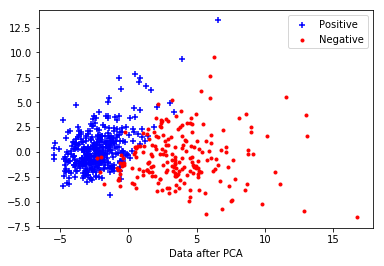

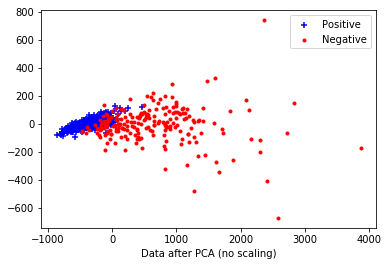

In [16]:
pca = PCA(n_components=2)
x_scaled = preprocessing.scale(x[:,:-1]) # We remove the indexing and make sure all the features are in N(0,1)
x_reduced = pca.fit_transform(x_scaled)


plt.scatter(x_reduced[[i == True for i in y], 0], x_reduced[[i == True for i in y], 1], c = 'b', 
            marker="+", label = 'Positive')                     
plt.scatter(x_reduced[[i == False for i in y], 0], x_reduced[[i == False for i in y], 1], c = 'r', 
            marker=".", label = 'Negative')         
plt.legend()
plt.xlabel('Data after PCA')

plt.show()



# And again without scaling. 
x_reduced = pca.fit_transform(x[:,0:-1]) # Uncomment this to see the result without scaling
plt.scatter(x_reduced[[i == True for i in y], 0], x_reduced[[i == True for i in y], 1], c = 'b', 
            marker="+", label = 'Positive')                     
plt.scatter(x_reduced[[i == False for i in y], 0], x_reduced[[i == False for i in y], 1], c = 'r', 
            marker=".", label = 'Negative')         
plt.legend()
plt.xlabel('Data after PCA (no scaling)')

plt.show()



    
# TODO come back to this one... 

    
    
    
# **************************************************************** 1 mark()

### Making a tree

In [30]:
tree = build_tree(x_train, y_train, max_depth = 5)            # 5 is a good number. 
predictions = predict(tree, x_train)
accuracy = np.array([predictions == y_train]).sum()
accuracy = (accuracy/len(y_train)) * 100                        #  normalization
print('accuracy in the training set:', accuracy, '%') 



# again for the testing set: 
tree = build_tree(x_train, y_train, max_depth = 5)             
predictions = predict(tree, x_test)
accuracy = np.array([predictions == y_test]).sum()
accuracy = (accuracy/len(y_test)) * 100                                    
print('accuracy in the testing set:' , accuracy, '%')

accuracy in the training set: 99.41348973607037 %
accuracy in the testing set: 90.35087719298247 %


In [23]:
#printing a tree as well 
print_tree(tree)



 [feature 22 <= 117.2]


   [feature 27 <= 0.1571]


     [feature 1 <= 21.28]


       [feature 20 <= 16.46]
         predict 1.0


       [20 > 16.46]


         [feature 0 <= 13.8]
           predict 0.0


         [0 > 13.8]
           predict 1.0


     [1 > 21.28]


       [feature 26 <= 0.1927]


         [feature 0 <= 14.74]
           predict 1.0


         [0 > 14.74]
           predict 0.0


       [26 > 0.1927]


         [feature 17 <= 0.01276]
           predict 0.0


         [17 > 0.01276]
           predict 1.0


   [27 > 0.1571]


     [feature 13 <= 17.67]
       predict 1.0


     [13 > 17.67]
       predict 0.0


 [22 > 117.2]


   [feature 8 <= 0.122]
     predict 1.0


   [8 > 0.122]
     predict 0.0


## Breast Cancer Wisconsin (Diagnostic) Database
A description of the dataset used is provided here.

Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - target class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208
    ===================================== ====== ======

    :Missing Attribute Values: None

    :Class Distribution: 212 - Malignant, 357 - Benign

    :Creator:  Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian

    :Donor: Nick Street

    :Date: November, 1995

This is a copy of the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset from https://goo.gl/U2Uwz2

Features are computed from a digitized image of a fine needle
aspirate (FNA) of a breast mass. They describe
characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using
Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree
Construction Via Linear Programming." Proceedings of the 4th
Midwest Artificial Intelligence and Cognitive Science Society,
pp. 97-101, 1992], a classification method which uses linear
programming to construct a decision tree.  Relevant features
were selected using an exhaustive search in the space of 1-4
features and 1-3 separating planes.

The actual linear program used to obtain the separating plane
in the 3-dimensional space is that described in:
[K. P. Bennett and O. L. Mangasarian: "Robust Linear
Programming Discrimination of Two Linearly Inseparable Sets",
Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:

```
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/
```

### References
   - W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction 
     for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on 
     Electronic Imaging: Science and Technology, volume 1905, pages 861-870,
     San Jose, CA, 1993.
   - O.L. Mangasarian, W.N. Street and W.H. Wolberg. Breast cancer diagnosis and 
     prognosis via linear programming. Operations Research, 43(4), pages 570-577, 
     July-August 1995.
   - W.H. Wolberg, W.N. Street, and O.L. Mangasarian. Machine learning techniques
     to diagnose breast cancer from fine-needle aspirates. Cancer Letters 77 (1994) 
     163-171.

### Separator ----------------------------------------------------------------------------------------------------------------

# Lab 2:  Decision trees
The following exercise takes you through for implementing decision trees. It involves data manipulation/visualisation, hyperparameter selection, recursion, and building a prediction model. We will use a binary classification problem: Breast cancer diagnosis.

## Marking and Submission

These lab exercises are marked, and contribute to your final grade. For this lab exercise there are 6 places where you are expected to enter your own code, for 15 marks overall. Every place you have to add code is indicated by

`# **************************************************************** n marks`

with instructions above the code block.

Please submit your completed workbook using Moodle before 5pm on the 31st October 2018. The workbook you submit must be an `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them. You will normally receive feedback within a week.


In [ ]:
%matplotlib inline
import numpy as np

from sklearn import datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt

## Import data
The first step of any machine learning problem is to load the data. In this tutorial you don't have to download any dataset since we are using a built-in dataset provided by the scikit learn package.

In [ ]:
data_all = ds.load_breast_cancer()

x = data_all.data               # 569 x 30
y = data_all.target             # 569. Binary outcome. 

y_names = data_all.target_names 
feature_names = data_all.feature_names         # names. 

## Breast Cancer Wisconsin (Diagnostic) Database
A description of the dataset used is provided here.

Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - target class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208
    ===================================== ====== ======

    :Missing Attribute Values: None

    :Class Distribution: 212 - Malignant, 357 - Benign

    :Creator:  Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian

    :Donor: Nick Street

    :Date: November, 1995

This is a copy of the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset from https://goo.gl/U2Uwz2

Features are computed from a digitized image of a fine needle
aspirate (FNA) of a breast mass. They describe
characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using
Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree
Construction Via Linear Programming." Proceedings of the 4th
Midwest Artificial Intelligence and Cognitive Science Society,
pp. 97-101, 1992], a classification method which uses linear
programming to construct a decision tree.  Relevant features
were selected using an exhaustive search in the space of 1-4
features and 1-3 separating planes.

The actual linear program used to obtain the separating plane
in the 3-dimensional space is that described in:
[K. P. Bennett and O. L. Mangasarian: "Robust Linear
Programming Discrimination of Two Linearly Inseparable Sets",
Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:

```
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/
```

### References
   - W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction 
     for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on 
     Electronic Imaging: Science and Technology, volume 1905, pages 861-870,
     San Jose, CA, 1993.
   - O.L. Mangasarian, W.N. Street and W.H. Wolberg. Breast cancer diagnosis and 
     prognosis via linear programming. Operations Research, 43(4), pages 570-577, 
     July-August 1995.
   - W.H. Wolberg, W.N. Street, and O.L. Mangasarian. Machine learning techniques
     to diagnose breast cancer from fine-needle aspirates. Cancer Letters 77 (1994) 
     163-171.
